Found images: ['image10_cvp.jpeg', 'image11_cvp.jpeg', 'image12_cvp.jpeg', 'image13_cvp.jpeg', 'image14_cvp.jpeg', 'image15_cvp.jpeg', 'image16_cvp.jpeg', 'image17_cvp.jpeg', 'image18_cvp.jpeg', 'image1_cvp.jpeg', 'image2_cvp.jpeg', 'image3_cvp.jpeg', 'image4_cvp.jpeg', 'image5_cvp.jpeg', 'image6_cvp.jpeg', 'image7_cvp.jpeg', 'image8_cvp.jpeg', 'image9_cvp.jpeg']


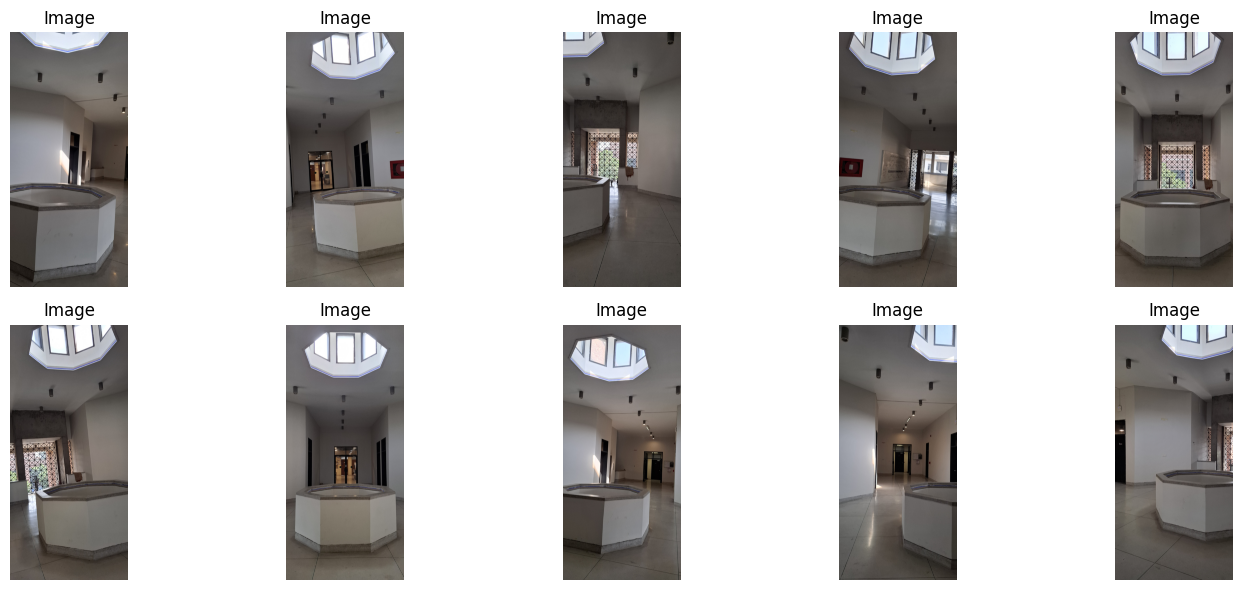

In [2]:
import cv2
import matplotlib.pyplot as plt
import glob, os
import random
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

image_folder = '/Users/ibrahimanwar/Downloads/prep/images'
image_paths = sorted(glob.glob(os.path.join(image_folder, 'image*_cvp.*')))
print("Found images:", [os.path.basename(p) for p in image_paths])

images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
sample_images = random.sample(images, min(10, len(images)))
plt.figure(figsize=(15,6))
for i, img in enumerate(sample_images):
    plt.subplot(2,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Image')
plt.tight_layout()
plt.show()


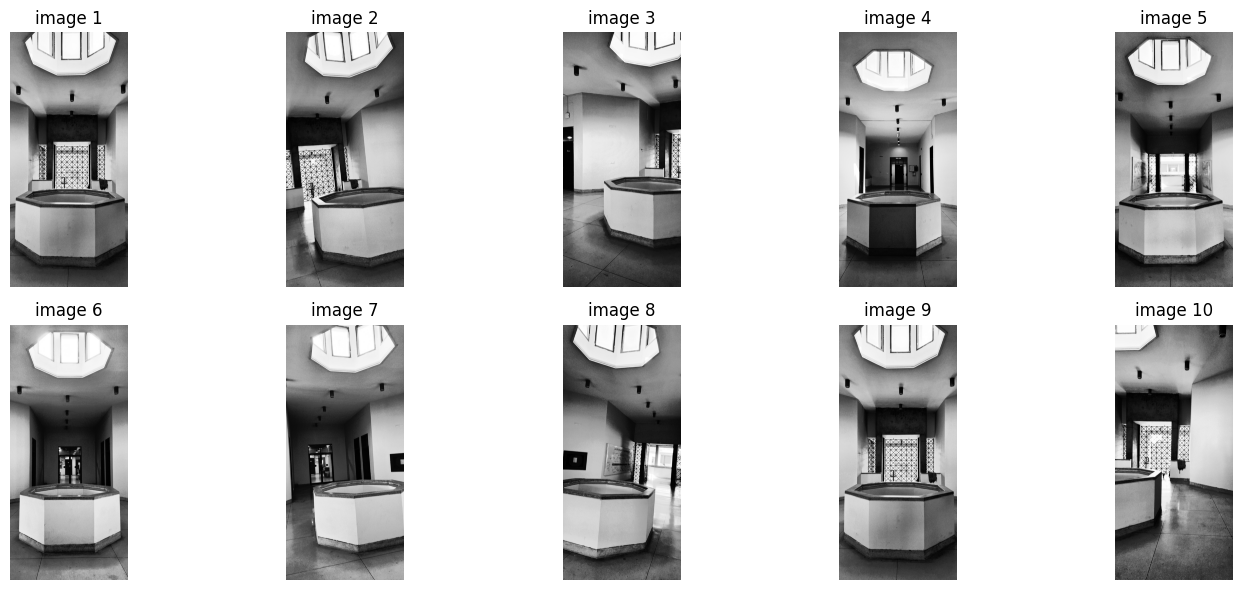

In [3]:
preprocessed_images = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    equalized = cv2.equalizeHist(blur)
    preprocessed_images.append(equalized)

plt.figure(figsize=(15,6))
for i, img in enumerate(random.sample(preprocessed_images, min(10, len(preprocessed_images)))):
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'image {i+1}')
plt.tight_layout()
plt.show()


Image 9 ↔ Image 14: Total matches = 8506, Lowe's matches = 8506


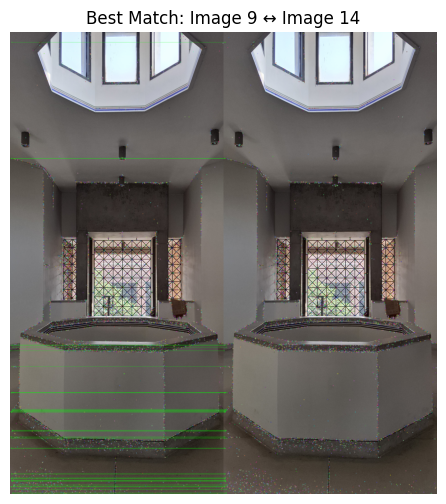

Image 7 ↔ Image 11: Total matches = 9286, Lowe's matches = 604


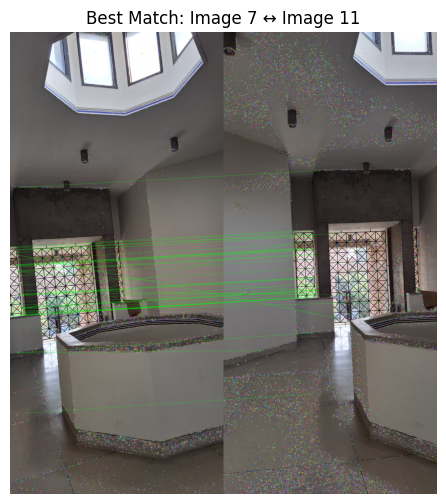

Image 6 ↔ Image 8: Total matches = 35076, Lowe's matches = 592


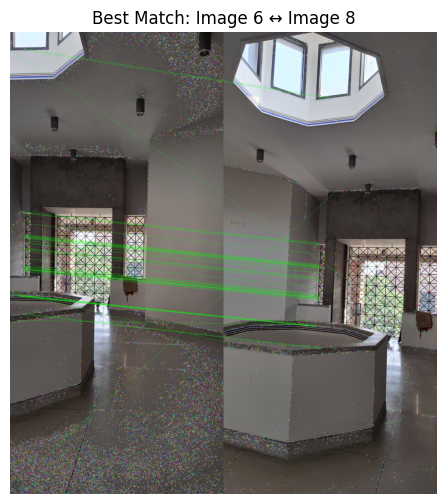

Image 8 ↔ Image 12: Total matches = 8293, Lowe's matches = 497


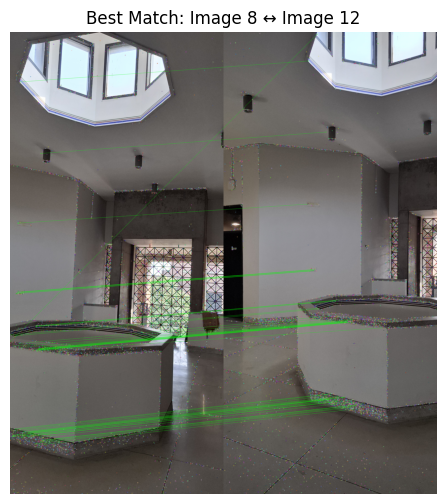

Image 6 ↔ Image 12: Total matches = 35076, Lowe's matches = 337


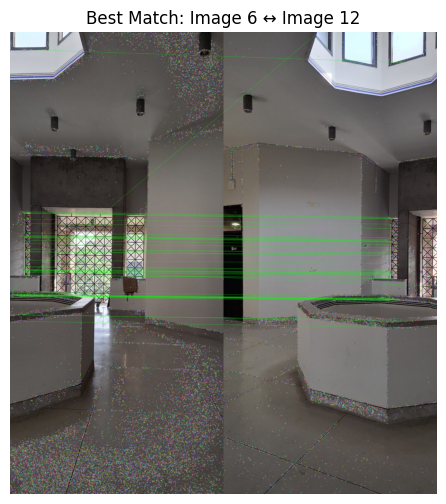

In [4]:
import numpy as np
sift = cv2.SIFT_create()
keys = []
descriptors = []
for img in preprocessed_images:
    kp, des = sift.detectAndCompute(img, None)
    keys.append(kp)
    descriptors.append(des)

bf = cv2.BFMatcher()
ratio_threshold = 0.70
pair_scores = []
for i, j in combinations(range(len(preprocessed_images)), 2):
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    pair_scores.append((i, j, len(matches), len(good_matches)))

pair_scores.sort(key=lambda x: x[3], reverse=True)
best_pairs = pair_scores[:5]
for i, j, total_matches, lowe_matches in best_pairs:
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    good_matches = good_matches[:50]
    matched_img = cv2.drawMatches(images[i], keys[i],images[j], keys[j],good_matches, None, matchColor=(0,255,0))
    print(f"Image {i+1} ↔ Image {j+1}: Total matches = {total_matches}, Lowe's matches = {lowe_matches}")
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Match: Image {i+1} ↔ Image {j+1}')
    plt.axis('off')
    plt.show()


In [5]:
def disparity_score(i, j):
    m = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    g = [m0 for m0, m1 in m if m0.distance / m1.distance < ratio_threshold]
    if len(g) < 50:
        return 0
    pts1_tmp = np.float32([keys[i][gm.queryIdx].pt for gm in g])
    pts2_tmp = np.float32([keys[j][gm.trainIdx].pt for gm in g])
    return np.mean(np.linalg.norm(pts1_tmp - pts2_tmp, axis=1))

pair_scores_geo = []
for (i, j, _, _) in pair_scores[:20]:
    d = disparity_score(i, j)
    pair_scores_geo.append((d, i, j))

pair_scores_geo.sort(reverse=True)
best_disp, i1, j1 = pair_scores_geo[0]
img1 = images[i1]
img2 = images[j1]
kp1 = keys[i1]
kp2 = keys[j1]
des1 = descriptors[i1]
des2 = descriptors[j1]

matches = bf.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in matches:
    if m.distance / n.distance < ratio_threshold:
        good_matches.append(m)

print("Good matches:", len(good_matches))

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

print("Matched points:", pts1.shape[0])

h, w = img1.shape[:2]
cx = w/2
cy = h/2
fx = fy = 4500.0
K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]],dtype=np.float64)

print("Intrinsic matrix K:\n", K)

E, mask_E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
print("Essential matrix E:\n", E)

mask_E = mask_E.ravel().astype(bool)
pts1_inliers = pts1[mask_E]
pts2_inliers = pts2[mask_E]

print("Inliers after Essential RANSAC:", pts1_inliers.shape[0])

_, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
mask_pose = mask_pose.ravel().astype(bool)

pts1_final = pts1_inliers[mask_pose]
pts2_final = pts2_inliers[mask_pose]

print("Inliers after recoverPose:", pts1_final.shape[0])
print("Rotation matrix R:\n", R)
print("Translation vector t:\n", t)
print("Baseline length:", np.linalg.norm(t))

R = R.astype(np.float64)
t = t.astype(np.float64)
K = K.astype(np.float64)

P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

print("Projection matrix P1:\n", P1)
print("Projection matrix P2:\n", P2)

pts1_h = pts1_final.T.reshape(2, -1).astype(np.float64)
pts2_h = pts2_final.T.reshape(2, -1).astype(np.float64)

points_h = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
points_3d = (points_h[:3] / points_h[3]).T
valid_mask = np.isfinite(points_3d).all(axis=1)
points_3d = points_3d[valid_mask]

print("Triangulated 3D points:", points_3d.shape[0])

points_3d = points_3d - np.mean(points_3d, axis=0)
scale = np.max(np.linalg.norm(points_3d, axis=1))
points_3d = points_3d / scale

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
colors = []
for (u, v) in pts1_final[valid_mask]:
    ui = int(round(u))
    vi = int(round(v))
    if 0 <= vi < img1_rgb.shape[0] and 0 <= ui < img1_rgb.shape[1]:
        r, g, b = img1_rgb[vi, ui]
    else:
        r, g, b = (255,255,255)
    colors.append([r, g, b])
colors = np.array(colors, dtype=np.uint8)

def save_ply(filename, points, colors):
    with open(filename, "w") as f:
        f.write("ply\nformat ascii 1.0\nelement vertex {}\n".format(points.shape[0]))
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n")
        for (x, y, z), (r, g, b) in zip(points, colors):
            f.write(f"{x} {y} {z} {r} {g} {b}\n")

save_ply("point_cloud.ply", points_3d, colors)

print("PLY saved:", "point_cloud.ply")
print("Final point count:", points_3d.shape[0])


Good matches: 337
Matched points: 337
Intrinsic matrix K:
 [[4.50e+03 0.00e+00 9.42e+02]
 [0.00e+00 4.50e+03 2.04e+03]
 [0.00e+00 0.00e+00 1.00e+00]]
Essential matrix E:
 [[ 0.11089714 -0.33683356 -0.08434464]
 [-0.33486269 -0.08538325  0.60897937]
 [ 0.09739564 -0.60557196  0.02546491]]
Inliers after Essential RANSAC: 92
Inliers after recoverPose: 92
Rotation matrix R:
 [[ 0.51739512 -0.04365956  0.85463216]
 [-0.07655138  0.99233233  0.09703836]
 [-0.85231577 -0.11563044  0.5100857 ]]
Translation vector t:
 [[-0.85689084]
 [-0.1394332 ]
 [ 0.49628264]]
Baseline length: 0.9999999999999999
Projection matrix P1:
 [[4.50e+03 0.00e+00 9.42e+02 0.00e+00]
 [0.00e+00 4.50e+03 2.04e+03 0.00e+00]
 [0.00e+00 0.00e+00 1.00e+00 0.00e+00]]
Projection matrix P2:
 [[ 1.52539659e+03 -3.05391897e+02  4.32634546e+03 -3.38851055e+03]
 [-2.08320538e+03  4.22960936e+03  1.47724745e+03  3.84967178e+02]
 [-8.52315772e-01 -1.15630444e-01  5.10085704e-01  4.96282643e-01]]
Triangulated 3D points: 92
PLY saved:

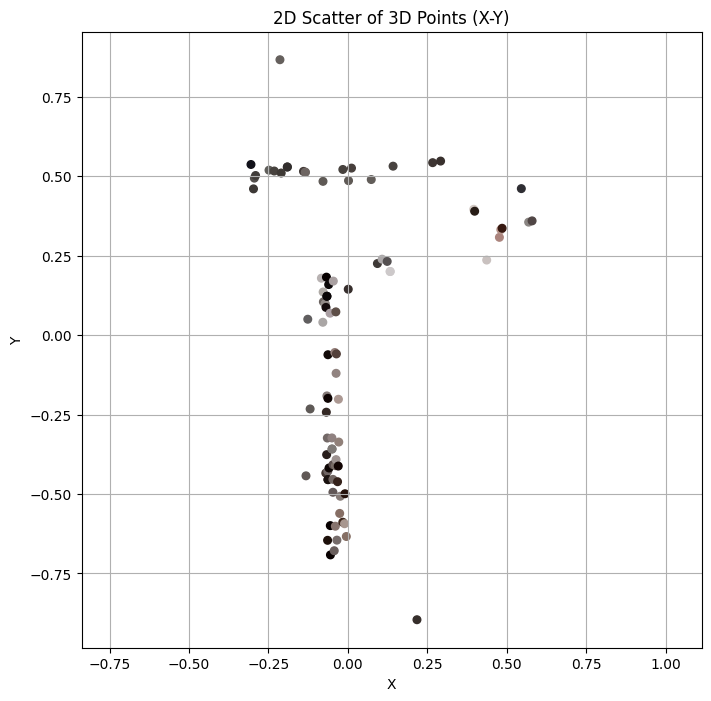

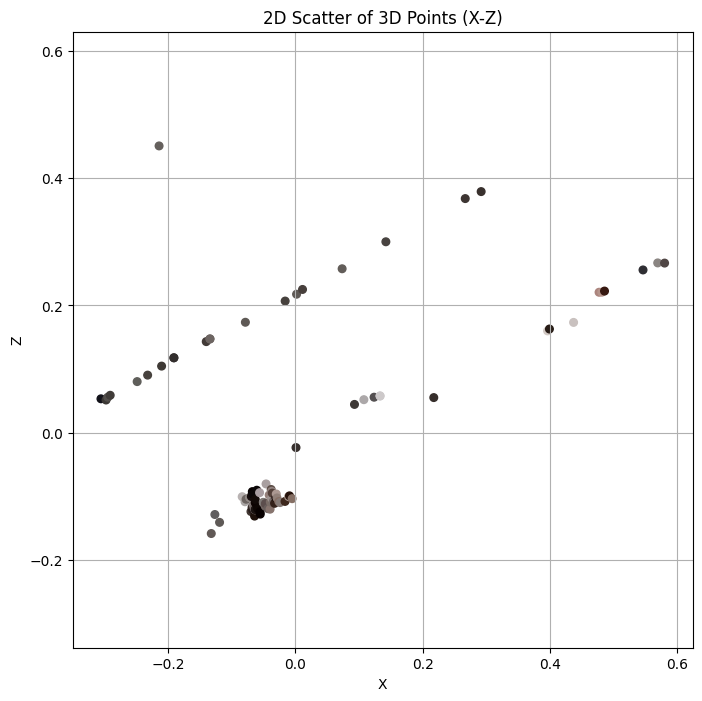

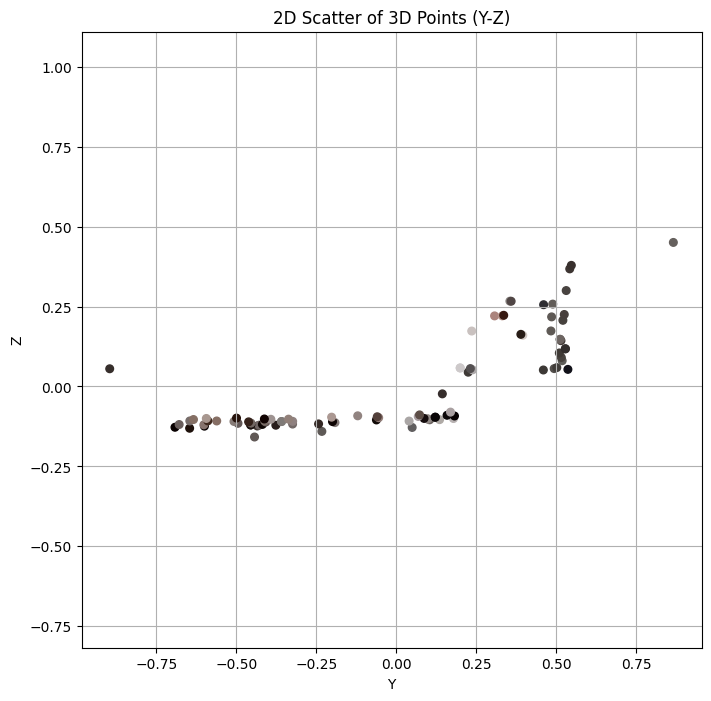

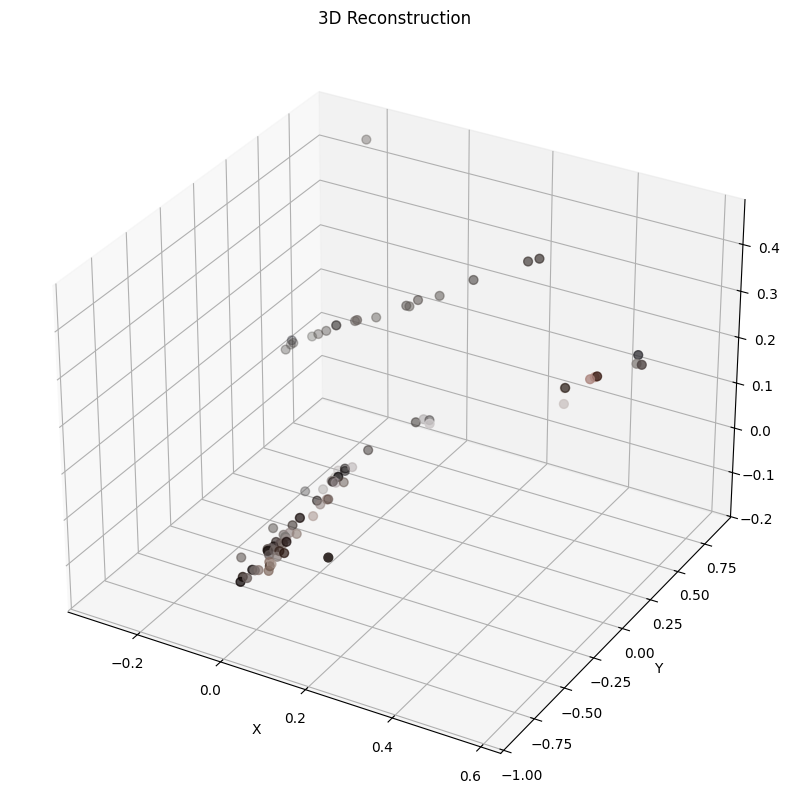

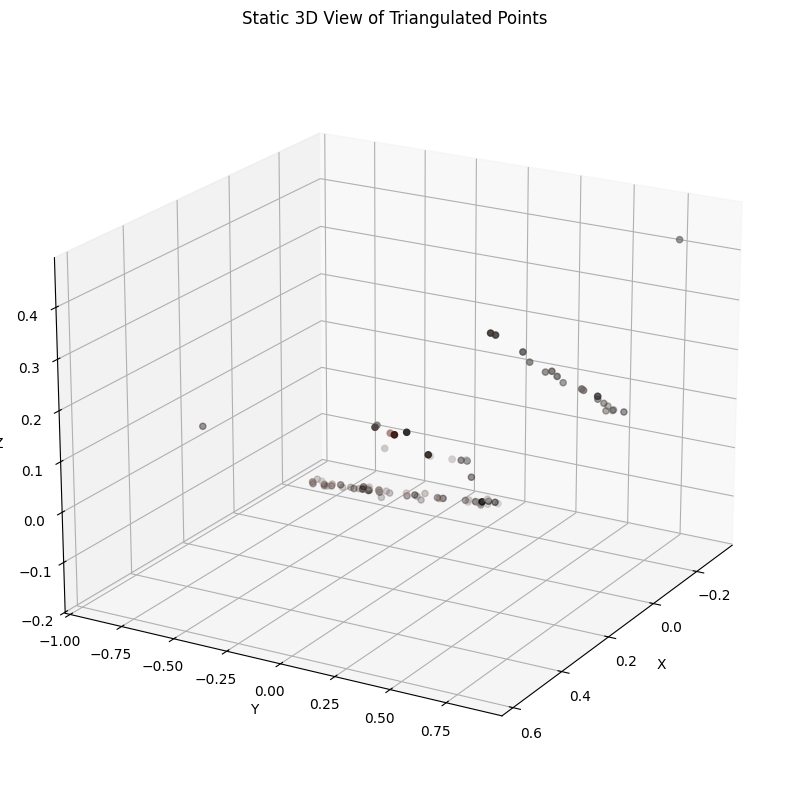

In [9]:
# 2D scatter of X-Y
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,1], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Scatter of 3D Points (X-Y)")
plt.grid(True)
plt.axis('equal')
plt.show()

# 2D scatter of X-Z
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (X-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()

# 2D scatter of Y-Z
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,1], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (Y-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()


# ---- 3D Scatter Visualization (interactive) ----
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], 
           c=colors/255.0, s=40)
ax.set_title("3D Reconstruction")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

# ---- Static 3D View ----
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = points_3d[:,0]
ys = points_3d[:,1]
zs = points_3d[:,2]

ax.scatter(xs, ys, zs, c=colors/255, s=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Static 3D View of Triangulated Points')

ax.view_init(elev=20, azim=30)
plt.show()


In [ ]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("point_cloud.ply")
print(pcd)
o3d.visualization.draw_geometries([pcd])


PointCloud with 92 points.


: 

In [ ]:
# min_matches_pnp = 40

# def disparity_score(i, j):
#     m = bf.knnMatch(descriptors[i], descriptors[j], k=2)
#     g = [m0 for m0, m1 in m if m0.distance / m1.distance < ratio_threshold]
#     if len(g) < 50:
#         return 0
#     pts1_tmp = np.float32([keys[i][gm.queryIdx].pt for gm in g])
#     pts2_tmp = np.float32([keys[j][gm.trainIdx].pt for gm in g])
#     return np.mean(np.linalg.norm(pts1_tmp - pts2_tmp, axis=1))

# pair_scores_geo = []
# for (i, j, _, _) in pair_scores[:20]:
#     d = disparity_score(i, j)
#     pair_scores_geo.append((d, i, j))
# pair_scores_geo.sort(reverse=True)
# base_disp, base_i, base_j = pair_scores_geo[0]
# print("Base stereo pair:", base_i, base_j, "disparity:", base_disp)

# img1 = images[base_i]
# img2 = images[base_j]
# kp1 = keys[base_i]
# kp2 = keys[base_j]
# des1 = descriptors[base_i]
# des2 = descriptors[base_j]

# matches = bf.knnMatch(des1, des2, k=2)
# good_matches = []
# for m, n in matches:
#     if m.distance / n.distance < ratio_threshold:
#         good_matches.append(m)

# pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
# pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# h, w = img1.shape[:2]
# cx = w / 2
# cy = h / 2
# fx = fy = 4500.0
# K = np.array([[fx, 0, cx],
#               [0, fy, cy],
#               [0,  0,  1]], dtype=np.float64)

# E, mask_E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
# mask_E = mask_E.ravel().astype(bool)
# pts1_inliers = pts1[mask_E]
# pts2_inliers = pts2[mask_E]
# good_inliers = [gm for gm, keep in zip(good_matches, mask_E) if keep]

# _, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
# mask_pose = mask_pose.ravel().astype(bool)
# pts1_final = pts1_inliers[mask_pose]
# pts2_final = pts2_inliers[mask_pose]
# good_inliers = [gm for gm, keep in zip(good_inliers, mask_pose) if keep]

# R = R.astype(np.float64)
# t = t.astype(np.float64)

# P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
# P2 = K @ np.hstack((R, t))

# pts1_h = pts1_final.T.reshape(2, -1).astype(np.float64)
# pts2_h = pts2_final.T.reshape(2, -1).astype(np.float64)

# points_h = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
# points_3d = (points_h[:3] / points_h[3]).T
# valid_mask_init = np.isfinite(points_3d).all(axis=1)
# points_3d = points_3d[valid_mask_init]
# good_inliers = [gm for gm, keep in zip(good_inliers, valid_mask_init) if keep]
# pts1_final = pts1_final[valid_mask_init]
# pts2_final = pts2_final[valid_mask_init]

# num_points = points_3d.shape[0]
# print("Initial 3D points from base pair:", num_points)

# camera_poses = {}
# camera_poses[base_i] = (np.eye(3), np.zeros((3, 1)))
# camera_poses[base_j] = (R, t)

# point_observations = [[] for _ in range(num_points)]
# kp_to_3d = {}

# for pid, gm in enumerate(good_inliers):
#     q_idx = gm.queryIdx
#     t_idx = gm.trainIdx
#     kp_to_3d[(base_i, q_idx)] = pid
#     kp_to_3d[(base_j, t_idx)] = pid
#     x1, y1 = kp1[q_idx].pt
#     x2, y2 = kp2[t_idx].pt
#     point_observations[pid].append((base_i, x1, y1))
#     point_observations[pid].append((base_j, x2, y2))

# registered = set([base_i, base_j])

# for img_idx in range(len(images)):
#     if img_idx in registered:
#         continue

#     des_new = descriptors[img_idx]
#     if des_new is None:
#         continue

#     kp_new = keys[img_idx]
#     all_X = []
#     all_x = []
#     all_match_kp_idx = []

#     for ref_idx in list(registered):
#         des_ref = descriptors[ref_idx]
#         kp_ref = keys[ref_idx]
#         mm = bf.knnMatch(des_new, des_ref, k=2)
#         for m, n in mm:
#             if m.distance / n.distance >= ratio_threshold:
#                 continue
#             ref_kp_idx = m.trainIdx
#             if (ref_idx, ref_kp_idx) in kp_to_3d:
#                 pid = kp_to_3d[(ref_idx, ref_kp_idx)]
#                 X = points_3d[pid]
#                 u, v = kp_new[m.queryIdx].pt
#                 all_X.append(X)
#                 all_x.append([u, v])
#                 all_match_kp_idx.append(m.queryIdx)

#     all_X = np.array(all_X, dtype=np.float64)
#     all_x = np.array(all_x, dtype=np.float64)

#     if all_X.shape[0] < min_matches_pnp:
#         continue

#     success, rvec, tvec, inliers_pnp = cv2.solvePnPRansac(all_X, all_x, K, None)
#     if not success:
#         continue

#     R_new, _ = cv2.Rodrigues(rvec)
#     t_new = tvec.reshape(3, 1)
#     camera_poses[img_idx] = (R_new, t_new)
#     registered.add(img_idx)

#     inliers_pnp = inliers_pnp.ravel()
#     for idx in inliers_pnp:
#         pid_candidates = []
#         ref_obs_count = 0
#         u, v = all_x[idx]
#         X_idx = all_X[idx]
#     print("Registered image", img_idx, "with", all_X.shape[0], "2D-3D matches")

# P_list = {}
# for idx, (R_i, t_i) in camera_poses.items():
#     P_list[idx] = K @ np.hstack((R_i, t_i))

# new_points = []
# new_colors = []
# obs_min_cam = 2

# for ref_idx in registered:
#     for img_idx in registered:
#         if img_idx <= ref_idx:
#             continue
#         des_ref = descriptors[ref_idx]
#         des_new = descriptors[img_idx]
#         kp_ref = keys[ref_idx]
#         kp_new = keys[img_idx]
#         mm = bf.knnMatch(des_ref, des_new, k=2)
#         match_pairs = []
#         for m, n in mm:
#             if m.distance / n.distance >= ratio_threshold:
#                 continue
#             if (ref_idx, m.queryIdx) in kp_to_3d:
#                 continue
#             match_pairs.append(m)

#         if len(match_pairs) < 30:
#             continue

#         pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in match_pairs])
#         pts_new = np.float32([kp_new[m.trainIdx].pt for m in match_pairs])

#         P_ref = P_list[ref_idx].astype(np.float64)
#         P_new = P_list[img_idx].astype(np.float64)
#         pts_ref_h = pts_ref.T.reshape(2, -1)
#         pts_new_h = pts_new.T.reshape(2, -1)
#         pts_ref_h = pts_ref_h.astype(np.float64)
#         pts_new_h = pts_new_h.astype(np.float64)

#         points_h = cv2.triangulatePoints(P_ref, P_new, pts_ref_h, pts_new_h)
#         X_new = (points_h[:3] / points_h[3]).T
#         valid_new = np.isfinite(X_new).all(axis=1)
#         X_new = X_new[valid_new]
#         pts_ref = pts_ref[valid_new]
#         pts_new = pts_new[valid_new]
#         match_pairs = [mp for mp, keep in zip(match_pairs, valid_new) if keep]

#         if X_new.shape[0] == 0:
#             continue

#         start_idx = len(points_3d)
#         points_3d = np.vstack([points_3d, X_new])
#         for k_idx, mp in enumerate(match_pairs):
#             pid = start_idx + k_idx
#             u_ref, v_ref = pts_ref[k_idx]
#             u_new, v_new = pts_new[k_idx]
#             point_observations.append([(ref_idx, u_ref, v_ref), (img_idx, u_new, v_new)])
#             kp_to_3d[(ref_idx, mp.queryIdx)] = pid
#             kp_to_3d[(img_idx, mp.trainIdx)] = pid

# print("Total 3D points before refinement:", points_3d.shape[0])

# def reprojection_error(points_3d, point_observations, camera_poses, K):
#     errs = []
#     for pid, X in enumerate(points_3d):
#         if pid >= len(point_observations):
#             continue
#         X_h = np.hstack([X, 1.0])
#         for (img_idx, u_obs, v_obs) in point_observations[pid]:
#             if img_idx not in camera_poses:
#                 continue
#             R_i, t_i = camera_poses[img_idx]
#             P_i = K @ np.hstack((R_i, t_i))
#             proj = P_i @ X_h
#             u = proj[0] / proj[2]
#             v = proj[1] / proj[2]
#             errs.append(np.sqrt((u - u_obs) ** 2 + (v - v_obs) ** 2))
#     if len(errs) == 0:
#         return None
#     return np.mean(errs)

# err_before = reprojection_error(points_3d, point_observations, camera_poses, K)
# print("Mean reprojection error before refinement:", err_before)

# for img_idx in camera_poses.keys():
#     if img_idx == base_i:
#         continue
#     X_list = []
#     x_list = []
#     for pid, X in enumerate(points_3d):
#         if pid >= len(point_observations):
#             continue
#         for (obs_idx, u, v) in point_observations[pid]:
#             if obs_idx == img_idx:
#                 X_list.append(X)
#                 x_list.append([u, v])
#     X_list = np.array(X_list, dtype=np.float64)
#     x_list = np.array(x_list, dtype=np.float64)
#     if X_list.shape[0] < min_matches_pnp:
#         continue
#     R_i, t_i = camera_poses[img_idx]
#     rvec_i, _ = cv2.Rodrigues(R_i)
#     success, rvec_ref, tvec_ref = cv2.solvePnP(X_list, x_list, K, None, rvec_i, t_i, useExtrinsicGuess=True)
#     if not success:
#         continue
#     R_ref, _ = cv2.Rodrigues(rvec_ref)
#     t_ref = tvec_ref.reshape(3, 1)
#     camera_poses[img_idx] = (R_ref, t_ref)

# err_after = reprojection_error(points_3d, point_observations, camera_poses, K)
# print("Mean reprojection error after refinement:", err_after)

# center = np.mean(points_3d, axis=0)
# points_3d = points_3d - center
# scale = np.percentile(np.linalg.norm(points_3d, axis=1), 95)
# points_3d = points_3d / (scale + 1e-6)

# colors = []
# default_color = np.array([200, 200, 200], dtype=np.uint8)
# for pid, obs in enumerate(point_observations):
#     if len(obs) == 0:
#         colors.append(default_color)
#         continue
#     img_idx, u, v = obs[0]
#     img_rgb = cv2.cvtColor(images[img_idx], cv2.COLOR_BGR2RGB)
#     ui = int(round(u))
#     vi = int(round(v))
#     if 0 <= vi < img_rgb.shape[0] and 0 <= ui < img_rgb.shape[1]:
#         r, g, b = img_rgb[vi, ui]
#     else:
#         r, g, b = default_color
#     colors.append([r, g, b])
# colors = np.array(colors, dtype=np.uint8)

# def save_ply(filename, points, colors):
#     with open(filename, "w") as f:
#         f.write("ply\nformat ascii 1.0\nelement vertex {}\n".format(points.shape[0]))
#         f.write("property float x\nproperty float y\nproperty float z\n")
#         f.write("property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n")
#         for (x, y, z), (r, g, b) in zip(points, colors):
#             f.write(f"{x} {y} {z} {r} {g} {b}\n")

# save_ply("point_cloud_multiview_refined.ply", points_3d, colors)
# print("Saved refined multi-view point cloud with", points_3d.shape[0], "points")

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=2)
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("Refined multi-view point cloud")
# plt.tight_layout()
# plt.show()
